In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm 
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)

## Implementation of AdaBoost with Boosting a Linear Regression Based Classifier

In [18]:
class LeastSquaresRegression(object):
    def __init__(self):
        self.weights = []
    
    def calcLeastSquares(self, X, y):
        xtranspose = np.transpose(X)
        xtransx = np.dot(xtranspose, X)
        if xtransx.shape[0] != xtransx.shape[1]:
            raise ValueError('Needs to be a square matrix for inverse')
        matinv = np.linalg.inv(xtransx)
        xtransy = np.dot(xtranspose, y)
        self.weights = np.dot(matinv, xtransy)

    def makePredictions(self, X):
        class_output = np.dot(X, self.weights)
        return np.sign(class_output)

In [19]:
class Boosting(object):

    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.N = self.X_train.shape[0]
        self.y_train = y_train
        self.weights = np.ones(self.N)/self.N
        self.epsilont = []
        self.alphas = []
        self.classifiers = []
        self.histogram = {}
        #self.num_estimators = T
        
    def doBoosting(self):
#         for t in range(self.num_estimators):
        for t in range(1500):
            output = np.random.choice(self.N, self.N, p=self.weights)
            
            for t in output:
                self.histogram[t] = self.histogram.get(t, 0) + 1
            
#             print output
            B_Xtrain = self.X_train[output]
            B_ytrain = self.y_train[output]
        
            ls = LeastSquaresRegression()
            ls.calcLeastSquares(B_Xtrain, B_ytrain)
#             print ls.weights
            Y_pred = ls.makePredictions(self.X_train)
            
#             print Y_pred
            
            e_t = np.sum((Y_pred != self.y_train) * self.weights)
#             print e_t
            if e_t > 0.5:
                ls.weights = -ls.weights
                Y_pred = ls.makePredictions(self.X_train)
                e_t = np.sum((Y_pred != self.y_train) * self.weights)
            
#             print e_t
            self.epsilont.append(e_t)

            alpha_t = 0.5 * np.log((1 - e_t)/e_t)
            self.alphas.append(alpha_t)
            self.classifiers.append(ls)
            
#             print alpha_t   
            self.weights = self.weights * np.exp(-alpha_t* Y_pred * self.y_train)
            self.weights = self.weights / np.sum(self.weights)

In [20]:
X_train = np.genfromtxt('boosting/X_train.csv', delimiter=',')
y_train = np.genfromtxt('boosting/y_train.csv')
X_test = np.genfromtxt('boosting/X_test.csv', delimiter=',')
y_test = np.genfromtxt('boosting/y_test.csv')


def append_column_one(data):    
    append_ones = np.ones((data.shape[0],1))
    data = np.hstack((append_ones, data))
    return data

X_train = append_column_one(X_train)
X_test = append_column_one(X_test)

In [21]:
training_error = []
testing_error = []

boost = Boosting(X_train, y_train)
boost.doBoosting()

for t in tqdm(range(1, 1501)):
    sum_train = np.zeros(X_train.shape[0])
    sum_test = np.zeros(X_test.shape[0])
    for i in range(t):
        alpha = boost.alphas[i]
        classifier = boost.classifiers[i]
#             print X_train.shape
#             print classifier.weights.shape
#             print np.dot(X_train, classifier.weights).shape
        sum_train += (alpha * classifier.makePredictions(X_train))
        sum_test += (alpha * classifier.makePredictions(X_test))
    fboost_train_pred = np.sign(sum_train)
    fboost_test_pred = np.sign(sum_test)

    training_error.append(np.sum(fboost_train_pred != y_train)/y_train.shape[0])
    testing_error.append(np.sum(fboost_test_pred != y_test)/y_test.shape[0])

100%|██████████| 1500/1500 [00:50<00:00, 29.75it/s]


### (a) Plotting the testing vs training error for t = 1, 2, ... 1500

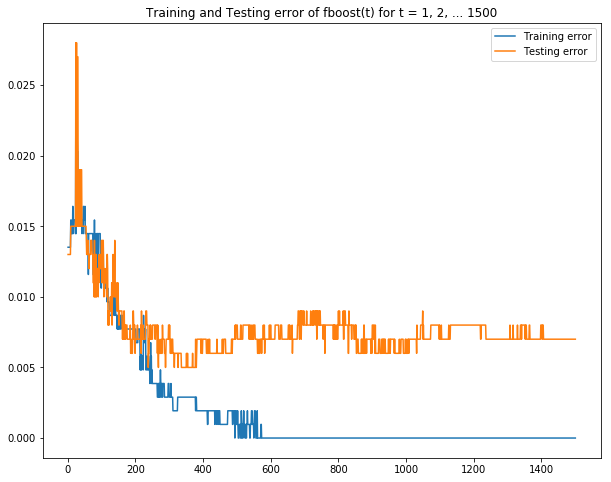

In [22]:
plt.figure()
plt.plot(range(1,1501), training_error, label="Training error")
plt.plot(range(1,1501), testing_error, label="Testing error")
plt.title("Training and Testing error of fboost(t) for t = 1, 2, ... 1500")
plt.legend()
plt.show()

### (b) Upper bound on the training error as a function of t

In [23]:
training_upper_bound = []
for t in tqdm(range(1, 1501)):
    ub = 0
    for i in range(t):
        epsilon = boost.epsilont[i]
        ub += np.power((0.5 - epsilon), 2)
    training_upper_bound.append(np.exp(-2 * ub))

100%|██████████| 1500/1500 [00:05<00:00, 272.81it/s]


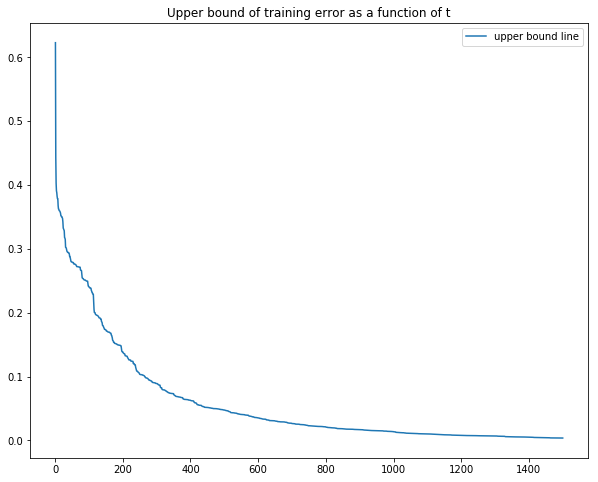

In [24]:
plt.figure()
plt.plot(range(1, 1501), training_upper_bound, label="upper bound line")
plt.title("Upper bound of training error as a function of t")
plt.legend()
plt.show()

### (c) Histogram of the dimensions

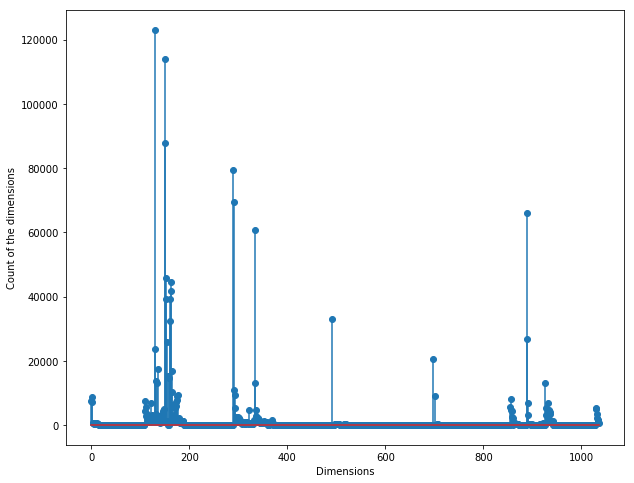

In [25]:
plt.figure()
plt.stem(list(boost.histogram.keys()), boost.histogram.values(), color='g')
plt.xlabel("Dimensions")
plt.ylabel("Count of the dimensions")
plt.show()

In [26]:
#np.sum(boost.histogram.values())

### (d) Epsilon and Alpha as a function of t

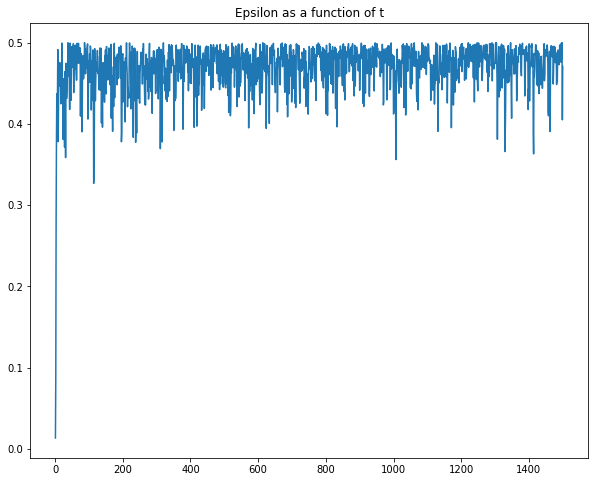

In [27]:
## Epsilon
plt.figure()
plt.plot(range(1, 1501), boost.epsilont)
plt.title("Epsilon as a function of t")
plt.show()

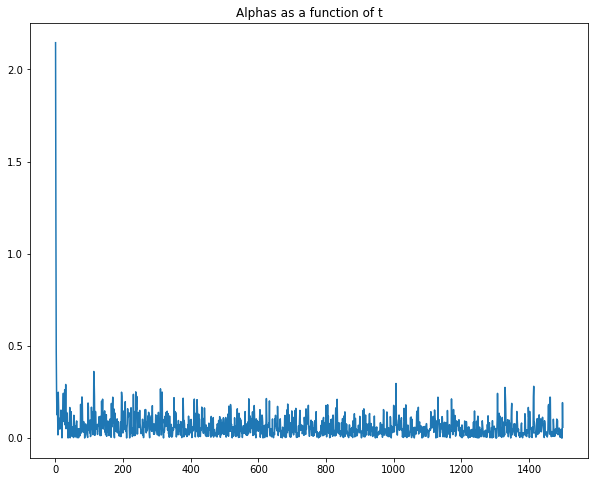

In [28]:
## Alphas
plt.figure()
plt.plot(range(1, 1501), boost.alphas)
plt.title("Alphas as a function of t")
plt.show()

---

---